<h1 style="color:black; background-color:#B2DFEE;padding:1%;border-radius:15px;text-align:left;font-family:Times New Roman;font-size:42px;">Air Passengers</h1>

<img src="https://www.tourdom.ru/upload/iblock/c27/c2735a94bd6d6bed245993260473510b.jpeg" alt="Образец изображения" width="1000" height ="600">

<h2 style="font-size:35px;color:#68838B;">Library Importing<h2>

In [1]:
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX 

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

<h2 style="font-size:35px;color:#68838B;">Exploratory Data Analysis<h2>

In [2]:
df = pd.read_csv(r"C:\Users\Hello Tasha\Desktop\1T_py\Homework\Task_2.7\AirPassengers.csv")
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


<p style = "font-color:black;font-size:18px; padding:1%; border:solid;border-width:thin;border-color:#68838B"> 
Time series has 144 objects and 2 columns: month and airplane passengers at this month. There are no gaps in the data. 
<p>

In [4]:
df['Month'] = pd.to_datetime(df['Month'], format="%Y-%m")
df = df.set_index('Month')
display(df.head())
print(f'Period data: [{df.index.min()} - {df.index.max()}]')

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Period data: [1949-01-01 00:00:00 - 1960-12-01 00:00:00]


In [5]:
df.index.is_monotonic_increasing

True

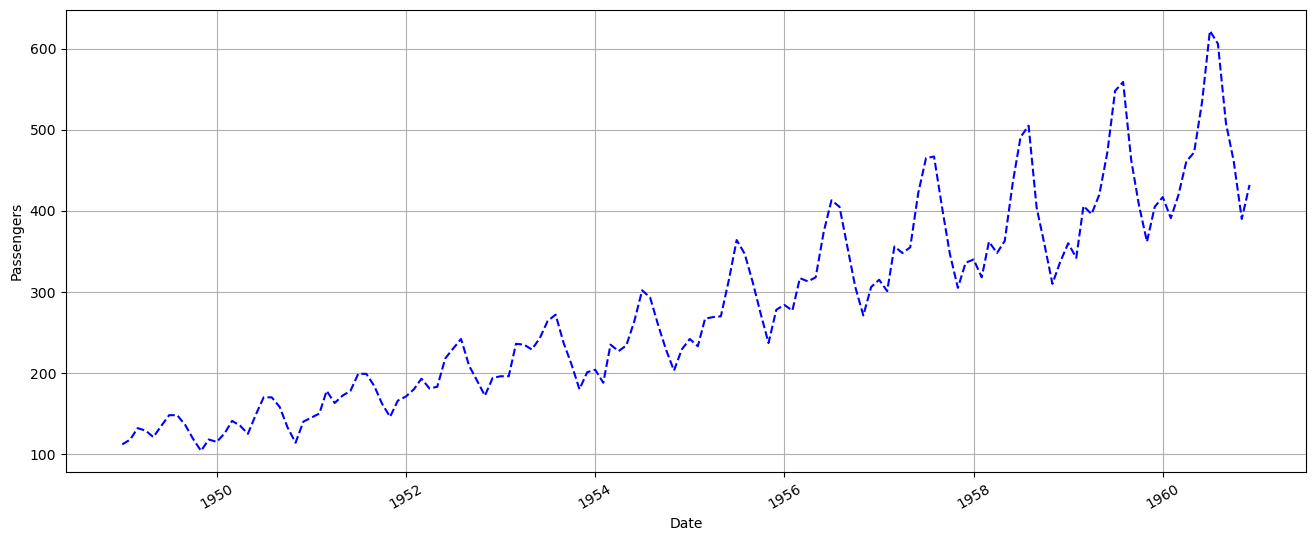

In [25]:
plt.figure(figsize=(16,6))
plt.plot(df.index, df.values, '--', color='blue')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.grid(True)
plt.xticks(rotation=30)

plt.show()

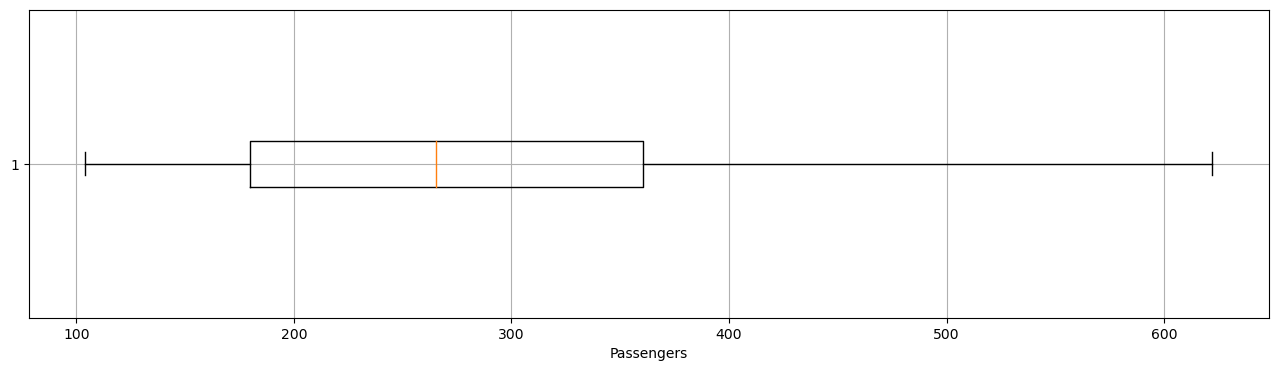

In [26]:
plt.figure(figsize=(16,4))
plt.boxplot(df.values,vert=False)
plt.xlabel('Passengers')
plt.grid(True)
plt.show()

<p style = "font-color:black;font-size:18px; padding:1%; border:solid;border-width:thin;border-color:#68838B"> 
Data hasn't outliers. Amount of airplane passengers definitely growing every year
<p>

In [6]:
df_first = df['1952':'1957']
print(f'Period data for research: [{df_first.index.min()} - {df_first.index.max()}]')

Period data for research: [1952-01-01 00:00:00 - 1957-12-01 00:00:00]


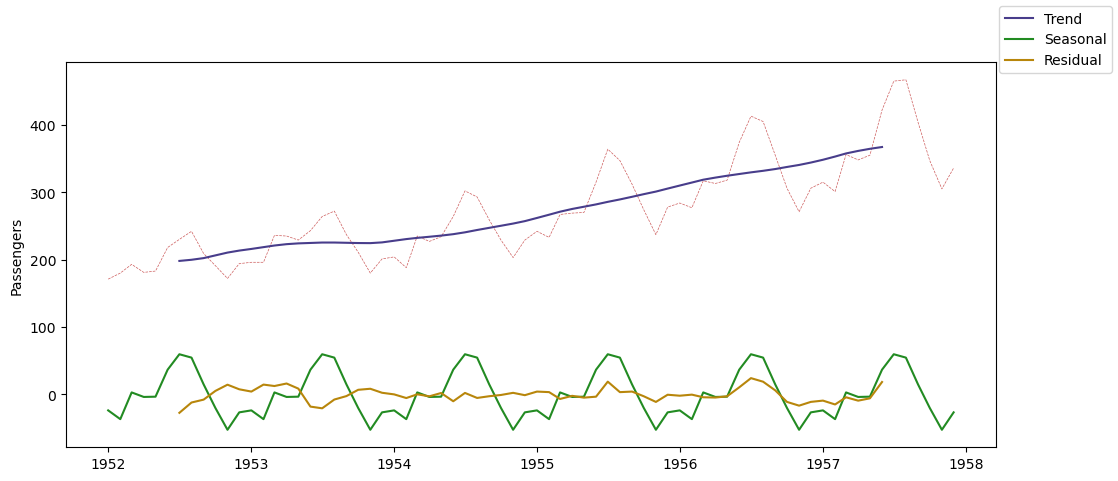

In [7]:
decomposed = seasonal_decompose(df_first['#Passengers']) 

fig, ax = plt.subplots(1, 1, figsize=[12, 5])

ax.plot(df_first['#Passengers'], c='indianred', linewidth=0.5, linestyle='--')
ax.plot(decomposed.trend, c='darkslateblue', label='Trend')
ax.plot(decomposed.seasonal, c='forestgreen', label='Seasonal')
ax.plot(decomposed.resid, c='darkgoldenrod', label='Residual')
ax.set_ylabel('Passengers')

fig.legend()

- <p style = 'font-size:20px'> According to the graph, the trend is growing <p>
- <p style = 'font-size:20px'> There is an annual seasonality, each year the schedule is cyclically repeated <p>
- <p style = 'font-size:20px'> The peak occurs around July-August of each year <p>
- <p style = 'font-size:20px'> The time series is not stationary, since the series has a trend, its average changes <p>


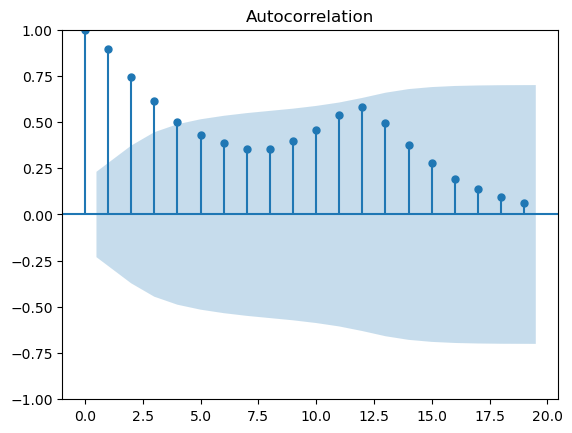

In [8]:
fig = tsaplots.plot_acf(df_first['#Passengers'])
plt.show() 

- <p style = 'font-size:20px'> Since all values are above 0, we can talk about an increasing trend.<p>
- <p style = 'font-size:20px'> At month 12, an increase in autocorrelation is visible, which confirms the annual seasonality, although all values after month 4 lie within the selected area and these shifts will not be productive. <p>

 

<h2 style="font-size:35px;color:#68838B;"> Preparing data for training<h2>

In [9]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['quarter'] = data.index.quarter
    
    for i in max_lag:
        data[f'lag_{i}'] = data['#Passengers'].shift(i)
    
    for i in rolling_mean_size:
        data[f'rolling_mean{i}'] = data['#Passengers'].rolling(i).mean()
        data[f'rolling_mean{i}'] = data[f'rolling_mean{i}'].shift(1)
    
    return data

In [10]:
max_lag=[1,2,12]
rolling_mean_size = [3]
df_first_with_features = make_features(df_first[['#Passengers']].copy(), max_lag, rolling_mean_size)
df_first_with_features.head()

,#Passengers,year,month,quarter,lag_1,lag_2,lag_12,rolling_mean3
Month,,,,,,,,
1952-01-01,171,1952,1,1,NaN,NaN,NaN,NaN
1952-02-01,180,1952,2,1,171.0,NaN,NaN,NaN
1952-03-01,193,1952,3,1,180.0,171.0,NaN,NaN
1952-04-01,181,1952,4,2,193.0,180.0,NaN,181.333333
1952-05-01,183,1952,5,2,181.0,193.0,NaN,184.666667


In [11]:
df_first_with_features = df_first_with_features.dropna()
df_first_with_features.head()

,#Passengers,year,month,quarter,lag_1,lag_2,lag_12,rolling_mean3
Month,,,,,,,,
1953-01-01,196,1953,1,1,194.0,172.0,171.0,185.666667
1953-02-01,196,1953,2,1,196.0,194.0,180.0,187.333333
1953-03-01,236,1953,3,1,196.0,196.0,193.0,195.333333
1953-04-01,235,1953,4,2,236.0,196.0,181.0,209.333333
1953-05-01,229,1953,5,2,235.0,236.0,183.0,222.333333


<p style = "font-color:black;font-size:18px; padding:1%; border:solid;border-width:thin;border-color:#68838B"> 
New features have been generated (calendar features, several columns with different shifts, several columns with different moving averages). Split data on next step
<p>

In [12]:
train, test = train_test_split(df_first_with_features, shuffle=False, test_size=0.2)

train_target = train['#Passengers']
train_features = train.drop(['#Passengers'], axis=1)
test_target = test['#Passengers']
test_features = test.drop(['#Passengers'], axis=1)

<h2 style="font-size:35px;color:#68838B;"> Model training<h2>

<h2 style="font-size:25px;color:#68838B;"> LinearRegression<h2>

In [13]:
model = LinearRegression()
model.fit(train_features, train_target)

train_prediction = pd.Series(model.predict(train_features)).round()
train_prediction.index = train_features.index
test_prediction = pd.Series(model.predict(test_features)).round()
test_prediction.index = test_features.index

print("MAE train sample:" ,mean_absolute_error(train_target, train_prediction))
print("MAE test sample: " ,mean_absolute_error(test_target, test_prediction))

MAE train sample: 9.875
MAE test sample:  11.666666666666666


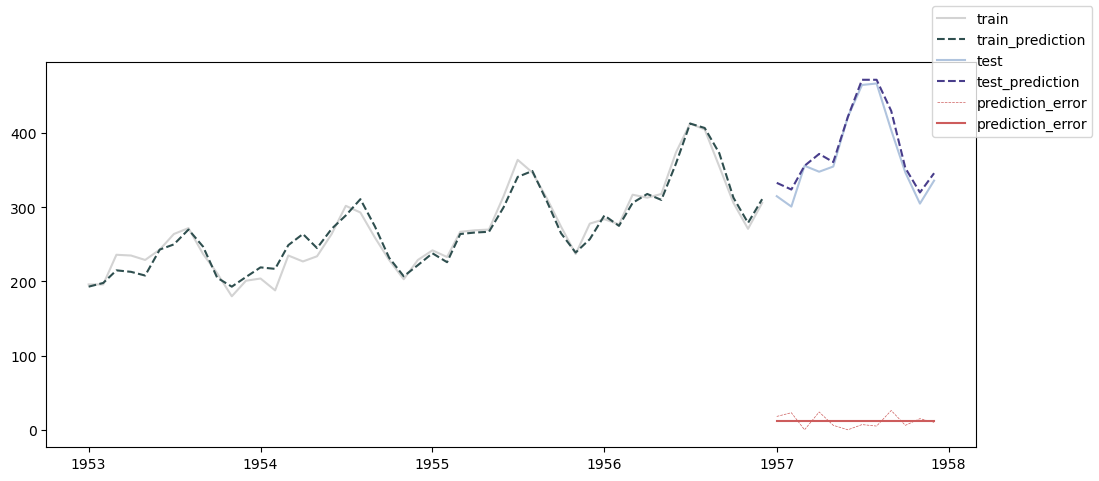

In [14]:
fig, ax = plt.subplots(1, 1, figsize=[12, 5])

error = abs(test['#Passengers'] - test_prediction)
error_mean = pd.Series([error.mean()] * error.shape[0])
error_mean.index = test.index

ax.plot(train_target, c='lightgrey', label='train')
ax.plot(train_prediction, c='darkslategrey', label='train_prediction', linestyle='--')
ax.plot(test_target, c='lightsteelblue', label='test')
ax.plot(test_prediction, c='darkslateblue', label='test_prediction', linestyle='--')
ax.plot(error, c='indianred', linestyle='--', label='prediction_error', linewidth=0.5)
ax.plot(error_mean, c='indianred', label='prediction_error')

fig.legend()

<p style = "font-color:black;font-size:18px; padding:1%; border:solid;border-width:thin;border-color:#68838B"> 
MAE test sample:  11.66
<p>

<h2 style="font-size:25px;color:#68838B;"> SARIMA<h2>

In [15]:
train, test = train_test_split(df_first, shuffle=False, test_size=0.2)

<p style = 'font-size:20px'> Determination of the differentiation parameter:<p>

In [16]:
result = adfuller(train)
print('p-value:', result[1])

p-value: 1.0


 <p style = "font-color:black;font-size:18px; padding:1%; border:solid;border-width:thin;border-color:#68838B"> 
Time series is not stationary as mentioned earlier
<p>


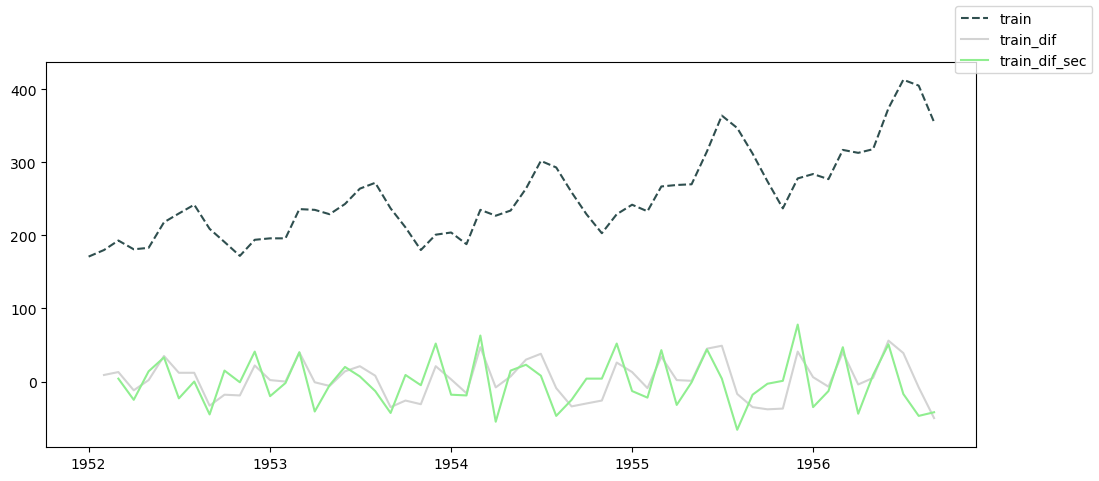

In [17]:
train_dif = train.diff()
train_dif_sec = train_dif.dropna().diff()

fig, ax = plt.subplots(1, 1, figsize=[12, 5])

ax.plot(train, c='darkslategrey', label='train', linestyle='--')
ax.plot(train_dif, c='lightgrey', label='train_dif')
ax.plot(train_dif_sec, c='lightgreen', label='train_dif_sec')
fig.legend()

In [18]:
result_first_dif = adfuller(train_dif.dropna())
result_second_dif = adfuller(train_dif_sec.dropna())
print('p-value (1 dif):', result_first_dif[1])
print('p-value (2 dif):', result_second_dif[1])

p-value (1 dif): 0.4121359485075054
p-value (2 dif): 9.09120957962612e-09


 <p style = "font-color:black;font-size:18px; padding:1%; border:solid;border-width:thin;border-color:#68838B"> 
In order for the series to become stationary according to the Dickey-Fuller criterion, the differentiation order is 2
<p>

In [19]:
model = SARIMAX(train, order = (1,0,0), seasonal_order=(1,2,1,12))
model_fit = model.fit()
predict = model_fit.predict(start=len(train),end=len(train)+len(test)-1)
print('MAE test sample:', mean_absolute_error(test,predict))

MAE test sample: 6.64780585962446


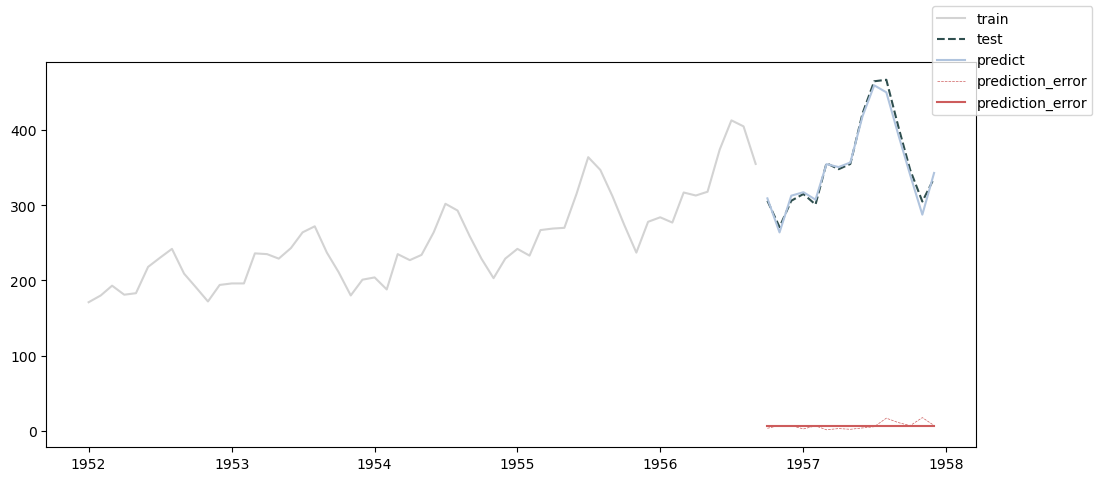

In [20]:
fig, ax = plt.subplots(1, 1, figsize=[12, 5])

error = abs(test['#Passengers'] - predict)
error_mean = pd.Series([error.mean()] * error.shape[0])
error_mean.index = test.index

ax.plot(train, c='lightgrey', label='train')
ax.plot(test, c='darkslategrey', label='test', linestyle='--')
ax.plot(predict, c='lightsteelblue', label='predict')
ax.plot(error, c='indianred', linestyle='--', label='prediction_error', linewidth=0.5)
ax.plot(error_mean, c='indianred', label='prediction_error')

fig.legend()

<p style = "font-color:black;font-size:18px; padding:1%; border:solid;border-width:thin;border-color:#68838B"> 
MAE test sample:  6.64
<p>

## <h2 style="font-size:35px;color:#68838B;">Conclusion<h2>

<p style = 'font-size:20px'> A research was conducted to predicting the number of air passengers. The following steps were completed during the EDA: <p>

- <p style = 'font-size:20px'> research of dataset, content and data types <p>
- <p style = 'font-size:20px'> checking emptinesses <p>
- <p style = 'font-size:20px'> checking data for outliers, data distribution <p>
- <p style = 'font-size:20px'> research seasonal, trend, residual parts <p>

<p style = 'font-size:20px'> Preparing data was conducted: <p>

- <p style = 'font-size:20px'> added new features (calendar features, several columns with different shifts, several columns with different moving averages) <p>
- <p style = 'font-size:20px'> deleted gaps <p>
- <p style = 'font-size:20px'> split data on train and test samples <p>

<p style = 'font-size:20px'> LinearRegression model and SARIMA model were built. MAE was defined for each model on test sample:: <p>

- <p style = 'font-size:20px'> LinearRegression MAE - 11.66 <p>
- <p style = 'font-size:20px'> SARIMA MAE -  6.64 <p>

<p style = 'font-size:20px'> As a result of the work performed, SARIMA model showed the best MAE (6.6) <p>